# Import unwrap

In [2]:
import sys
!{sys.executable} -m pip uninstall -y unwrap
!{sys.executable} -m pip install --no-deps -U --no-cache git+https://github.com/jgraving/unwrap

Found existing installation: unwrap 0.0.1
Uninstalling unwrap-0.0.1:
  Successfully uninstalled unwrap-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/jgraving/unwrap to c:\users\james foster\appdata\local\temp\pip-req-build-6bnfmdfg
  Resolved https://github.com/jgraving/unwrap to commit 48e371b3a1a5af14f3f2e8fd0abe0b5c451be9bd
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for unwrap: filename=unwrap-0.0.1-py3-none-any.whl size=13551 sha256=eba4047d62fa364ef1c993cb782338d18e2d254b0d1f183d8fdf477bdf3a5a46
  Stored in directory: C:\Users\James Foster\AppData\Local\Temp\pip-ephem-wheel-cache-73e_3isv\wheels\6d\a6\84\e3cfe169b27e40b37f18ed01b9a2ce83462e4b2ccd53a02794
Successfully built unwrap


  Running command git clone --filter=blob:none --quiet https://github.com/jgraving/unwrap 'C:\Users\James Foster\AppData\Local\Temp\pip-req-build-6bnfmdfg'


# Read in data

In [3]:
import pandas as pd
import numpy as np
from unwrap.link.numpy import shifted_modulo

# Load the file
file_path = 'SecurityLightBergsig.txt'
df = pd.read_csv(file_path, sep='\t')

# Create a binary indicator for the Light (1 for 'ON', 0 for 'OFF')
df['Light'] = df['Experiment'].apply(lambda x: 1 if 'ON' in x else 0)

# Convert the 'Heading' column from degrees to radians
df['Heading'] = pd.to_numeric(df['Heading'], errors='coerce')  # Convert non-numeric values (e.g., 'NA') to NaN
df['HeadingRadians'] = np.deg2rad(df['Heading'])

# Normalize the heading radians to be between -pi and pi
df['HeadingRadians'] = df['HeadingRadians'].apply(lambda x: shifted_modulo(x) if pd.notnull(x) else x)

# Keep only the relevant columns and drop rows with missing values
df = df[['Light', 'Beetle', 'Trial', 'HeadingRadians']].dropna().copy()
df.reset_index(drop=True, inplace=True)

# Rename columns: change 'Beetle' to 'Individual'
df = df.rename(columns={'Beetle': 'Individual'})
df['Individual'] = df['Individual'].astype('category')

df.head()


Light Individual  Trial  HeadingRadians
0      1          1      1        2.617994
1      1          1      2       -2.792527
2      1          1      3       -2.792527
3      1          1      4       -2.617994
4      1          1      5       -2.617994

# Plot data

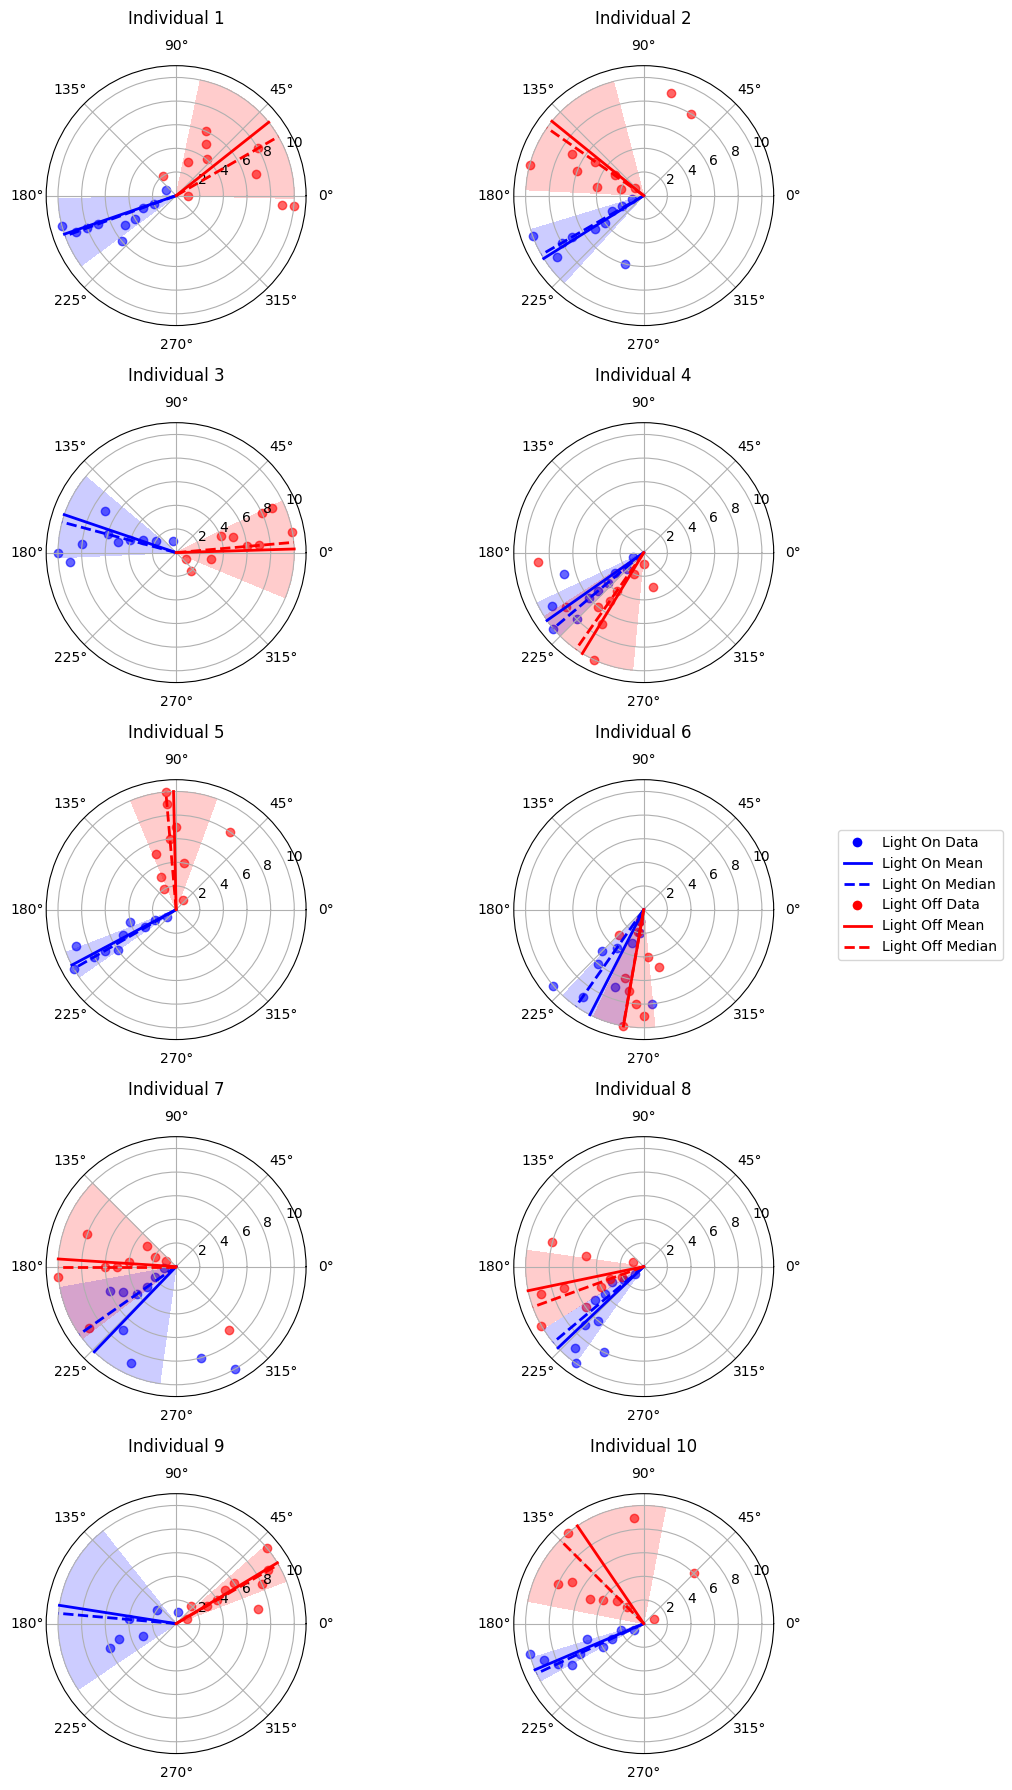

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import circmean, circstd
from matplotlib.lines import Line2D

# Helper function to compute the circular median.
def circ_median(angles):
    angles = np.sort(angles)
    diffs = np.abs(np.angle(np.exp(1j * (angles[:, None] - angles[None, :]))))
    sum_diffs = np.sum(diffs, axis=1)
    return angles[np.argmin(sum_diffs)]

# Helper function to scatter-plot data for one condition.
def plot_scatter(ax, data, angle_col, radial_col, color, label):
    if not data.empty:
        ax.scatter(data[angle_col], data[radial_col],
                   color=color, alpha=0.6, label=label)

# Helper function to compute and plot summary statistics.
# It plots a solid vertical line at the circular mean and a dashed vertical line at the circular median,
# both in the specified color. It also fills the region ± the circular standard deviation.
def plot_summary_stats(ax, angles, radial_max, color):
    # Compute circular mean, median, and standard deviation.
    mean_val = circmean(angles, high=np.pi, low=-np.pi)
    median_val = circ_median(angles)
    std_val = circstd(angles, high=np.pi, low=-np.pi, normalize=True)
    
    # Plot mean (solid) and median (dashed).
    ax.plot([mean_val, mean_val], [0, radial_max], color=color, linewidth=2)
    ax.plot([median_val, median_val], [0, radial_max], color=color, linewidth=2, linestyle='--')
    
    # Fill the region between mean minus std and mean plus std.
    theta_vals = np.linspace(mean_val - std_val, mean_val + std_val, 100)
    r_vals = np.linspace(0, radial_max, 100)
    Theta, R = np.meshgrid(theta_vals, r_vals)
    ax.contourf(Theta, R, np.ones_like(Theta), alpha=0.2, colors=[color])
    
    return mean_val, median_val, std_val

# Get unique individual IDs.
unique_individuals = df['Individual'].unique()

# Create a grid of polar subplots.
n_plots = len(unique_individuals)
n_rows, n_cols = 5, 2  # Adjust grid dimensions as needed.
fig, axes = plt.subplots(n_rows, n_cols, subplot_kw={'projection': 'polar'}, figsize=(10, 18))
axes = axes.flatten()

radial_max = 10  # Maximum radial value

# Plot for each individual.
for idx, individual in enumerate(unique_individuals):
    ax = axes[idx]
    individual_data = df[df['Individual'] == individual]
    
    # Separate Light On and Light Off data (drop NaNs in HeadingRadians).
    data_on = individual_data[individual_data['Light'] == 1].dropna(subset=['HeadingRadians'])
    data_off = individual_data[individual_data['Light'] == 0].dropna(subset=['HeadingRadians'])
    
    # Scatter-plot data.
    plot_scatter(ax, data_on, 'HeadingRadians', 'Trial', 'blue', 'Light On')
    plot_scatter(ax, data_off, 'HeadingRadians', 'Trial', 'red', 'Light Off')
    
    # Plot summary statistics for each condition.
    if not data_on.empty:
        plot_summary_stats(ax, data_on['HeadingRadians'].values, radial_max, 'blue')
    if not data_off.empty:
        plot_summary_stats(ax, data_off['HeadingRadians'].values, radial_max, 'red')
    
    ax.set_title(f'Individual {individual}', pad=30)
    ax.set_ylim(0, radial_max + 1)
    # Remove individual legends from each subplot.
    ax.legend().set_visible(False)

# Create a shared custom legend.
legend_handles = [
    # For Light On (blue)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Light On Data'),
    Line2D([0], [0], color='blue', lw=2, label='Light On Mean'),
    Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Light On Median'),
    # For Light Off (red)
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Light Off Data'),
    Line2D([0], [0], color='red', lw=2, label='Light Off Mean'),
    Line2D([0], [0], color='red', lw=2, linestyle='--', label='Light Off Median'),
]

# Add one shared legend to the right of the figure.
fig.legend(handles=legend_handles, loc='center right', bbox_to_anchor=(1.10, 0.5), fontsize='medium')

plt.tight_layout()
plt.show()


# Initial model

In [5]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    "Light": bmb.Prior("Normal", mu=0, sigma=0.1 * np.pi),
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
    ),
    "Light|Individual": bmb.Prior(
        "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model = bmb.Model(
    formula,
    df,
    family="vonmises",
    priors=priors,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model)

# Fit the model.
idata = model.fit(draws=1000)


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ Normal(mu: 0.0, sigma: 0.3142)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 1.6094, sigma: 0.1))
            Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -1.3863, sigma: 0.1))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 1.8546, sigma: 1.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_sigma, Light|Individual_offset, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


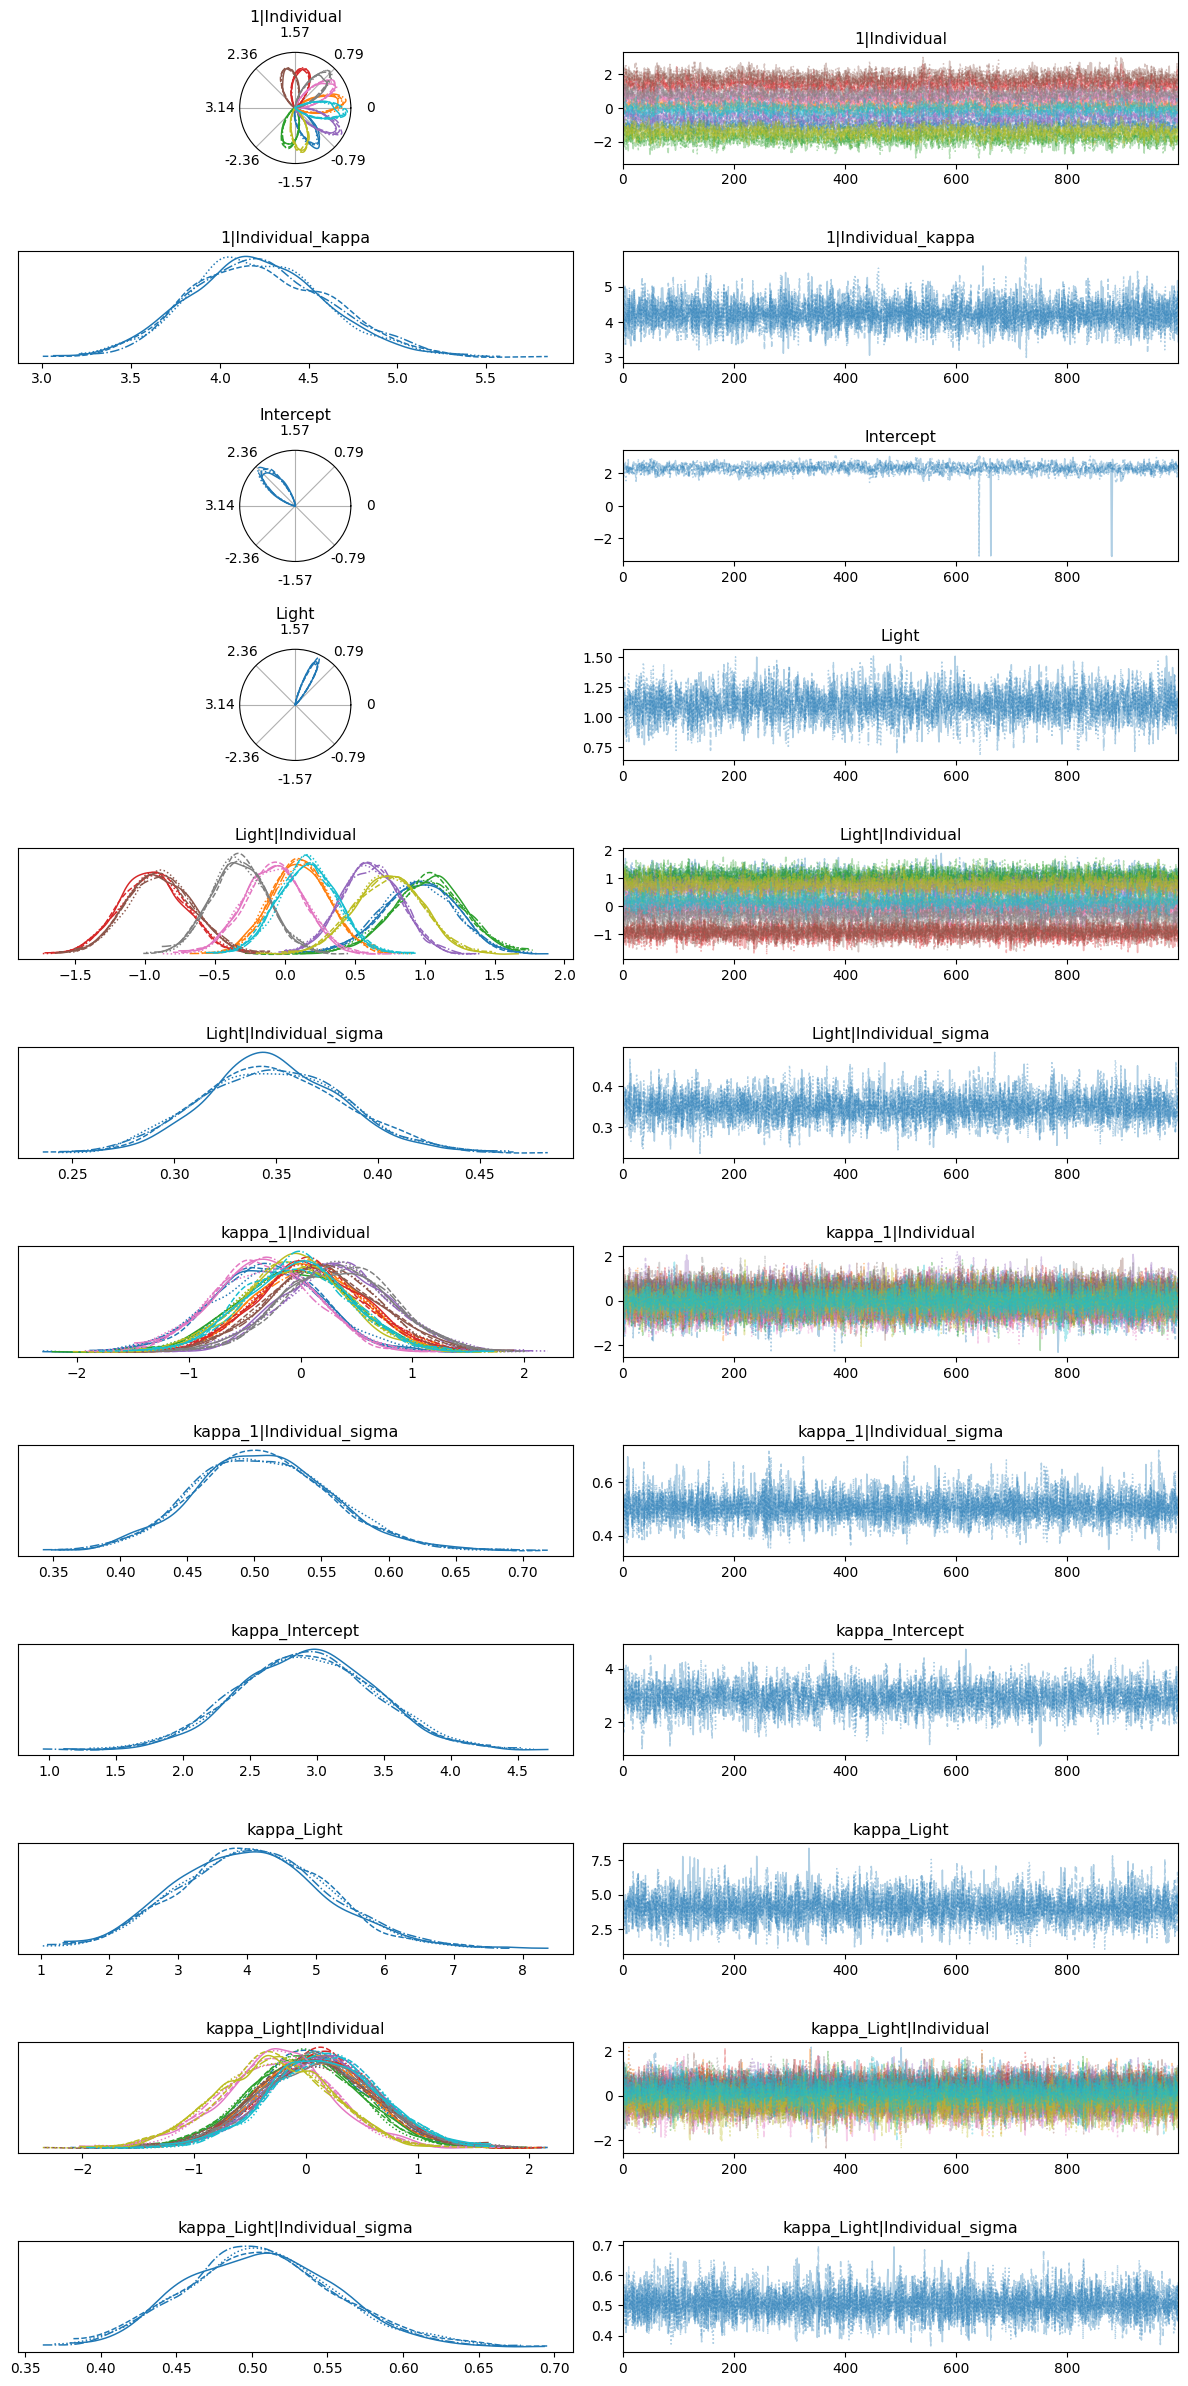

In [6]:
az.plot_trace(idata, circ_var_names=["Light", "Intercept", "1|Individual"])
plt.tight_layout()
plt.show()

In [7]:
az.summary(
    idata, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        2.328  0.248   1.867    2.782      0.004    0.006    1168.0   
Light            1.108  0.127   0.859    1.339      0.001    0.002    3408.0   
kappa_Intercept  2.920  0.508   1.923    3.815      0.008    0.006    3653.0   
kappa_Light      4.088  1.076   2.089    6.070      0.013    0.010    6404.0   

                 ess_tail  r_hat  
Intercept          1979.0    1.0  
Light              3160.0    1.0  
kappa_Intercept    3130.0    1.0  
kappa_Light        3155.0    1.0

In [8]:
az.summary(
    idata, 
    circ_var_names=["Intercept", "Light", "1|Individual"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1|Individual[1]              -1.041  0.322  -1.626   -0.411      0.007   
1|Individual[2]               0.143  0.277  -0.361    0.680      0.004   
1|Individual[3]              -1.774  0.343  -2.416   -1.129      0.007   
1|Individual[4]               1.366  0.327   0.792    2.003      0.003   
1|Individual[5]              -0.493  0.274  -1.017    0.012      0.005   
1|Individual[6]               1.806  0.328   1.211    2.417      0.004   
1|Individual[7]               0.598  0.289   0.049    1.134      0.006   
1|Individual[8]               0.828  0.280   0.287    1.320      0.005   
1|Individual[9]              -1.408  0.305  -1.983   -0.846      0.004   
1|Individual[10]             -0.080  0.276  -0.598    0.423      0.004   
1|Individual_kappa            4.225  0.386   3.550    5.001      0.004   
Intercept                     2.328  0.248   1.867    2.782      0.004   
Light                         1.108  0.127   0.859    1.339      0.001   
Light|Individual[1]           0.953  0.268   0.442    1.455      0.004   
Light|Individual[2]           0.110  0.208  -0.302    0.479      0.003   
Light|Individual[3]           1.021  0.266   0.521    1.528      0.004   
Light|Individual[4]          -0.937  0.240  -1.386   -0.497      0.003   
Light|Individual[5]           0.614  0.211   0.206    1.001      0.003   
Light|Individual[6]          -0.891  0.239  -1.327   -0.439      0.003   
Light|Individual[7]          -0.075  0.216  -0.474    0.325      0.003   
Light|Individual[8]          -0.324  0.204  -0.701    0.068      0.003   
Light|Individual[9]           0.741  0.243   0.273    1.175      0.003   
Light|Individual[10]          0.165  0.211  -0.226    0.566      0.003   
Light|Individual_sigma        0.349  0.035   0.287    0.418      0.001   
kappa_1|Individual[1]        -0.307  0.493  -1.291    0.576      0.006   
kappa_1|Individual[2]         0.077  0.478  -0.782    1.035      0.005   
kappa_1|Individual[3]        -0.056  0.504  -0.982    0.873      0.006   
kappa_1|Individual[4]         0.084  0.489  -0.871    0.973      0.005   
kappa_1|Individual[5]         0.316  0.494  -0.607    1.216      0.006   
kappa_1|Individual[6]         0.193  0.496  -0.796    1.083      0.006   
kappa_1|Individual[7]        -0.322  0.463  -1.186    0.532      0.005   
kappa_1|Individual[8]         0.331  0.484  -0.533    1.283      0.005   
kappa_1|Individual[9]        -0.046  0.474  -0.975    0.832      0.005   
kappa_1|Individual[10]       -0.026  0.472  -0.889    0.860      0.005   
kappa_1|Individual_sigma      0.507  0.052   0.407    0.601      0.001   
kappa_Intercept               2.920  0.508   1.923    3.815      0.008   
kappa_Light                   4.088  1.076   2.089    6.070      0.013   
kappa_Light|Individual[1]     0.052  0.508  -0.887    1.027      0.006   
kappa_Light|Individual[2]     0.073  0.498  -0.828    1.046      0.005   
kappa_Light|Individual[3]    -0.022  0.499  -1.018    0.864      0.005   
kappa_Light|Individual[4]     0.128  0.495  -0.801    1.038      0.005   
kappa_Light|Individual[5]     0.143  0.493  -0.876    0.999      0.005   
kappa_Light|Individual[6]     0.056  0.520  -0.890    1.038      0.006   
kappa_Light|Individual[7]    -0.256  0.502  -1.260    0.660      0.005   
kappa_Light|Individual[8]     0.120  0.516  -0.832    1.108      0.005   
kappa_Light|Individual[9]    -0.288  0.510  -1.213    0.673      0.005   
kappa_Light|Individual[10]    0.168  0.496  -0.780    1.096      0.005   
kappa_Light|Individual_sigma  0.506  0.050   0.411    0.599      0.000   

                              mcse_sd  ess_bulk  ess_tail  r_hat  
1|Individual[1]                 0.005    1879.0    2634.0   1.00  
1|Individual[2]                 0.005    1594.0    2277.0   1.00  
1|Individual[3]                 0.006    1641.0    2440.0   1.00  
1|Individual[4]                 0.006    1682.0    2124.0   1.00  
1|Individual[5]                 0.005    1506.0    2732.0   1.00  
1|

## Plot intitial model

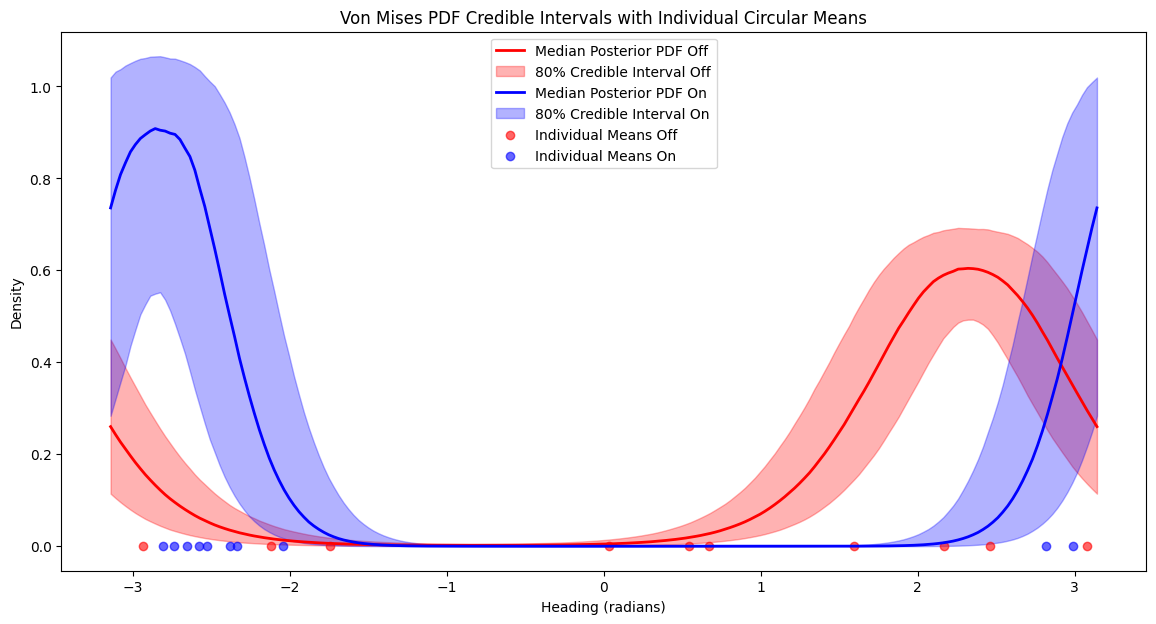

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises, circmean

# Import shifted_modulo and softplus from unwrap.link.numpy
from unwrap.link.numpy import shifted_modulo, softplus

# --------------------------------------------------
# Extract posterior samples for population-level parameters
# using the Bambi naming scheme with capitalized variable names.
# --------------------------------------------------
# For the μ-model (the main target):
mu_intercept = idata.posterior['Intercept'].values          # fixed intercept for μ
mu_slope     = idata.posterior['Light'].values               # fixed slope for μ

# For the κ-model:
kappa_intercept = idata.posterior['kappa_Intercept'].values    # fixed intercept for κ (linear predictor)
kappa_slope     = idata.posterior['kappa_Light'].values        # fixed slope for κ (linear predictor)

# --------------------------------------------------
# Prepare a grid for plotting the von Mises PDFs
# --------------------------------------------------
theta = np.linspace(-np.pi, np.pi, 200)

fig, ax = plt.subplots(figsize=(14, 7))

# Total number of posterior samples available.
num_samples = mu_intercept.flatten().shape[0]

# Compute population-level parameters for each condition.
mu_pop_off_samples_all = shifted_modulo(mu_intercept.flatten())
mu_pop_on_samples_all  = shifted_modulo((mu_intercept + mu_slope).flatten())
kappa_pop_off_samples_all = softplus(kappa_intercept.flatten())
kappa_pop_on_samples_all  = softplus((kappa_intercept + kappa_slope).flatten())

# --------------------------------------------------
# Compute the von Mises PDF for each posterior sample at each theta.
# The resulting arrays have shape (num_samples, len(theta)).
# --------------------------------------------------
pdf_off = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_off_samples_all[:, None],
    loc=mu_pop_off_samples_all[:, None]
)
pdf_on = vonmises.pdf(
    theta[None, :],
    kappa=kappa_pop_on_samples_all[:, None],
    loc=mu_pop_on_samples_all[:, None]
)

# For each theta, compute the median and the 95% credible interval.
median_pdf_off = np.median(pdf_off, axis=0)
lower_pdf_off  = np.percentile(pdf_off, 10, axis=0)
upper_pdf_off  = np.percentile(pdf_off, 90, axis=0)

median_pdf_on = np.median(pdf_on, axis=0)
lower_pdf_on  = np.percentile(pdf_on, 10, axis=0)
upper_pdf_on  = np.percentile(pdf_on, 90, axis=0)

# --------------------------------------------------
# Plot the median PDFs and fill between the 95% credible intervals.
# --------------------------------------------------
ax.plot(theta, median_pdf_off, color='red', lw=2, label='Median Posterior PDF Off')
ax.fill_between(theta, lower_pdf_off, upper_pdf_off, color='red', alpha=0.3,
                label='80% Credible Interval Off')

ax.plot(theta, median_pdf_on, color='blue', lw=2, label='Median Posterior PDF On')
ax.fill_between(theta, lower_pdf_on, upper_pdf_on, color='blue', alpha=0.3,
                label='80% Credible Interval On')

# --------------------------------------------------
# Plot the circular means for each individual (individual-level summaries)
# --------------------------------------------------
for i, individual in enumerate(df['Individual'].unique()):
    individual_data = df[df['Individual'] == individual]
    
    # Get headings for Light Off (Light == 0) and Light On (Light == 1)
    headings_off = individual_data.loc[individual_data['Light'] == 0, 'HeadingRadians'].dropna()
    headings_on  = individual_data.loc[individual_data['Light'] == 1, 'HeadingRadians'].dropna()
    
    # Compute circular means for this individual and wrap into [-π, π] using shifted_modulo.
    individual_circmean_off = shifted_modulo(circmean(headings_off))
    individual_circmean_on  = shifted_modulo(circmean(headings_on))
    
    # Plot individual circular means.
    ax.scatter(individual_circmean_off, 0, color='red', alpha=0.6,
               label='Individual Means Off' if i == 0 else "")
    ax.scatter(individual_circmean_on, 0, color='blue', alpha=0.6,
               label='Individual Means On' if i == 0 else "")

ax.set_title('Von Mises PDF Credible Intervals with Individual Circular Means')
ax.set_xlabel('Heading (radians)')
ax.set_ylabel('Density')
ax.legend()
plt.show()


## Plot population-level predictions

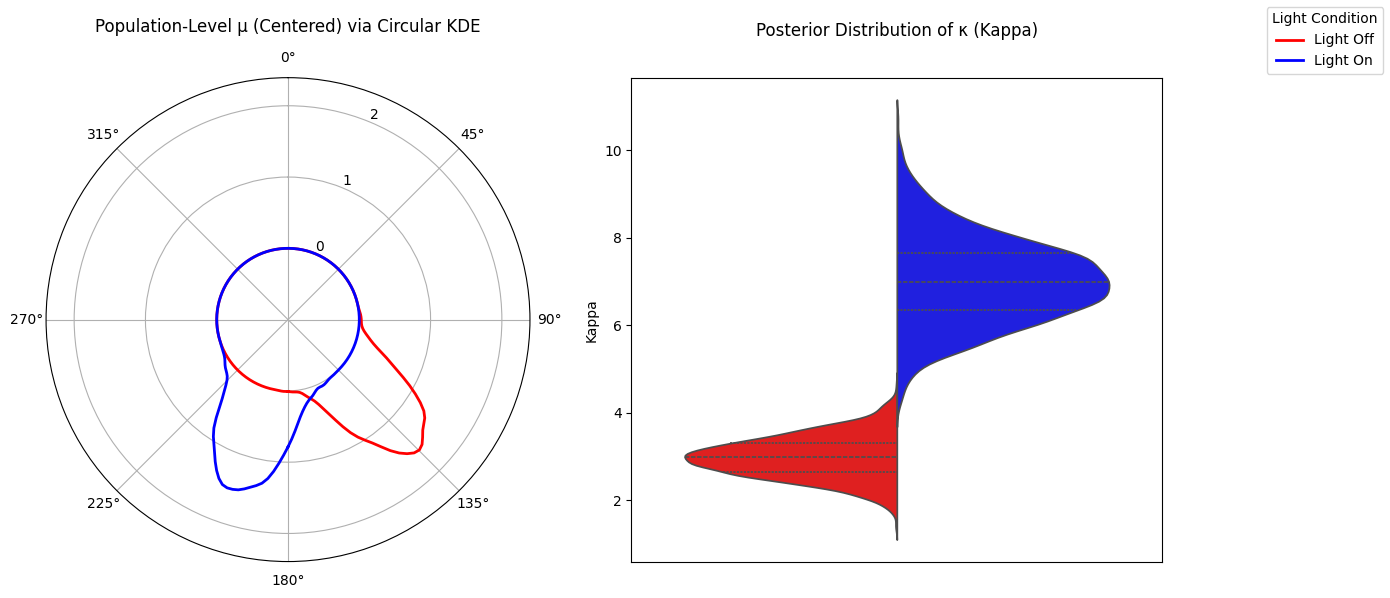

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import circmean, vonmises
from unwrap.link.numpy import shifted_modulo

# --------------------------------------------------
# Assume these arrays are computed from your posterior:
#   mu_pop_off_samples_all, mu_pop_on_samples_all,
#   kappa_pop_off_samples_all, kappa_pop_on_samples_all
# --------------------------------------------------

# ---------------------------
# Process μ (Mu) Samples
# ---------------------------
# Combine all μ samples to compute a common circular center.
mu_all = np.concatenate([mu_pop_off_samples_all, mu_pop_on_samples_all])
common_mu_center = circmean(mu_all, high=np.pi, low=-np.pi)

# Center the μ samples relative to the common center.
mu_off_centered = shifted_modulo(mu_pop_off_samples_all)
mu_on_centered  = shifted_modulo(mu_pop_on_samples_all)

# Set up an angular grid for the circular KDE.
theta = np.linspace(-np.pi, np.pi, 200)

# Choose a bandwidth (concentration) for the von Mises kernel.
kappa_bandwidth = 500  # Adjust as needed

# Compute the circular KDE for each condition.
# For each sample, evaluate the von Mises PDF at each theta, then average over samples.
kde_mu_off = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_off_centered[:, None]),
    axis=0
)
kde_mu_on = np.mean(
    vonmises.pdf(theta[None, :],
                 kappa=kappa_bandwidth,
                 loc=mu_on_centered[:, None]),
    axis=0
)

# ---------------------------
# Process κ (Kappa) Samples
# ---------------------------
# For κ (a non-circular variable), no special centering is needed.
kappa_off = kappa_pop_off_samples_all
kappa_on  = kappa_pop_on_samples_all

# Create a DataFrame for the κ split violin plot.
df_kappa = pd.DataFrame({
    "Parameter": ["Kappa"] * (len(kappa_off) + len(kappa_on)),
    "Light": ["Light Off"] * len(kappa_off) + ["Light On"] * len(kappa_on),
    "Value": np.concatenate([kappa_off, kappa_on])
})

# --------------------------------------------------
# Create Subplots: a Polar Plot for μ and a Violin Plot for κ
# --------------------------------------------------
fig = plt.figure(figsize=(14, 6))

# (A) Polar subplot for μ.
ax1 = fig.add_subplot(1, 2, 1, projection='polar')
# Set axes to geographic format (clockwise, 0° at the top)
ax1.set_theta_zero_location('N')#place 0° at the top
ax1.set_theta_direction(-1)#reverse to clockwise
# Add an offset of 1 unit to the density so there's white space in the center.
ax1.plot(theta, kde_mu_off + 1, color='red', lw=2, label='Light Off')
ax1.plot(theta, kde_mu_on + 1, color='blue', lw=2, label='Light On')
ax1.set_title("Population-Level μ (Centered) via Circular KDE", va='bottom', pad=30)
# Adjust radial limits: add 1 (the offset) to the maximum density and a little extra space.
max_density = max(np.max(kde_mu_off), np.max(kde_mu_on))
ax1.set_rlim(0, 1 + max_density * 1.5)
ax1.set_rticks([1, 2, 3], [0, 1, 2])
# (B) Cartesian subplot for κ.
ax2 = fig.add_subplot(1, 2, 2)
sns.violinplot(x="Parameter", y="Value", hue="Light",
               data=df_kappa, split=True, inner="quartile",
               palette={"Light Off": "red", "Light On": "blue"},
               ax=ax2)
ax2.set_title("Posterior Distribution of κ (Kappa)", pad=30)
ax2.set_xlabel("")
ax2.set_ylabel("Kappa")
ax2.set_xticks([])
# --------------------------------------------------
# Create a Common Legend for Both Subplots
# --------------------------------------------------
# Remove individual legends from each subplot.
if ax1.get_legend() is not None:
    ax1.get_legend().remove()
if ax2.get_legend() is not None:
    ax2.get_legend().remove()

# Extract legend handles and labels from one of the subplots.
handles, labels = ax1.get_legend_handles_labels()

# Place a common legend for the entire figure.
fig.legend(handles, labels, title="Light Condition", loc="upper right")

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to leave space for the legend.
plt.show()


# Model with larger treatment effect on hyperparameters
Did I actually want to change anything here?

In [34]:
import numpy as np
import pandas as pd
import bambi as bmb
import arviz as az
import matplotlib.pyplot as plt

from unwrap.link.bambi import LINKS
from unwrap.link.numpy import inverse_softplus
from unwrap.prior import CircularUniformPrior

# Define the model formula with updated, capitalized variable names.
formula_hyper = bmb.Formula(
    "HeadingRadians ~ Light + (1 + Light|Individual)",
    "kappa ~ Light + (1 + Light|Individual)",
)

# Specify priors for the model with capitalized keys and updated variable names.
priors_hyper = {
    # Fixed effects for μ:
    "Intercept": CircularUniformPrior(),
    # "Light": bmb.Prior("Normal", mu=0, sigma= 0.75 * np.pi),#wider
    "Light": bmb.Prior("VonMises", mu=0, kappa= 1.0),#von Mises
    # Individual-level effects for μ:
    "1|Individual": bmb.Prior(
        # "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(5), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # 20251021 proposed shrinkage prior
    ),
    "Light|Individual": bmb.Prior(
        # "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.25), sigma=0.1)
        "VonMises", mu=0, kappa=bmb.Prior("LogNormal", mu=np.log(30), sigma=0.6) # my assumed potential for large changes 
    ),
    # Priors for the κ-model (inside the "kappa" dictionary):
    "kappa": {
        # Fixed effects for κ:
        # "Intercept": bmb.Prior("Normal", mu=inverse_softplus(2), sigma=1),
        "Intercept": bmb.Prior("Normal", mu=inverse_softplus(3), sigma=3),#wider possible range
        "Light": bmb.Prior("Normal", mu=0, sigma=2.5),
        # Individual-level effects for κ:
        "1|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
        "Light|Individual": bmb.Prior(
            "Normal", mu=0, sigma=bmb.Prior("LogNormal", mu=np.log(0.5), sigma=0.1)
        ),
    },
}

# Build the model using the updated formula and priors.
model_hyper = bmb.Model(
    formula_hyper,
    df,
    family="vonmises",
    priors=priors_hyper,
    link={"mu": LINKS["shifted_modulo"], "kappa": LINKS["softplus"]},
    center_predictors=False,
    dropna=True,
)

print(model_hyper)

# Fit the model.
idata_hyper = model_hyper.fit(draws=1000)


       Formula: HeadingRadians ~ Light + (1 + Light|Individual)
                kappa ~ Light + (1 + Light|Individual)
        Family: vonmises
          Link: mu = shifted_modulo
                kappa = softplus
  Observations: 196
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ CircularUniform()
            Light ~ VonMises(mu: 0.0, kappa: 1.0)
        
        Group-level effects
            1|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
            Light|Individual ~ VonMises(mu: 0.0, kappa: LogNormal(mu: 3.4012, sigma: 0.6))
    target = kappa
        Common-level effects
            kappa_Intercept ~ Normal(mu: 2.9489, sigma: 3.0)
            kappa_Light ~ Normal(mu: 0.0, sigma: 2.5)
        
        Group-level effects
            kappa_1|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))
            kappa_Light|Individual ~ Normal(mu: 0.0, sigma: LogNormal(mu: -0.6931, sigma: 0.1))


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Light, 1|Individual_kappa, 1|Individual, Light|Individual_kappa, Light|Individual, kappa_Intercept, kappa_Light, kappa_1|Individual_sigma, kappa_1|Individual_offset, kappa_Light|Individual_sigma, kappa_Light|Individual_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 89 seconds.


## Inspect summary


In [35]:
az.summary(
    idata_hyper, 
    var_names=["Intercept", "Light", "kappa_Intercept", "kappa_Light", "1|Individual_kappa", "Light|Individual_kappa"],
    circ_var_names=["Intercept", "Light"]
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept               2.224  0.543   1.200   -3.090      0.021    0.029   
Light                   1.317  0.282   0.800    1.868      0.015    0.007   
kappa_Intercept         4.152  0.571   3.070    5.212      0.008    0.006   
kappa_Light             3.359  1.098   1.158    5.290      0.016    0.012   
1|Individual_kappa      1.835  0.481   0.997    2.736      0.007    0.005   
Light|Individual_kappa  2.740  0.750   1.474    4.202      0.011    0.008   

                        ess_bulk  ess_tail  r_hat  
Intercept                 1081.0     857.0   1.01  
Light                      910.0    1292.0   1.01  
kappa_Intercept           5006.0    3365.0   1.00  
kappa_Light               5032.0    3057.0   1.00  
1|Individual_kappa        4579.0    2203.0   1.00  
Light|Individual_kappa    5052.0    3073.0   1.00

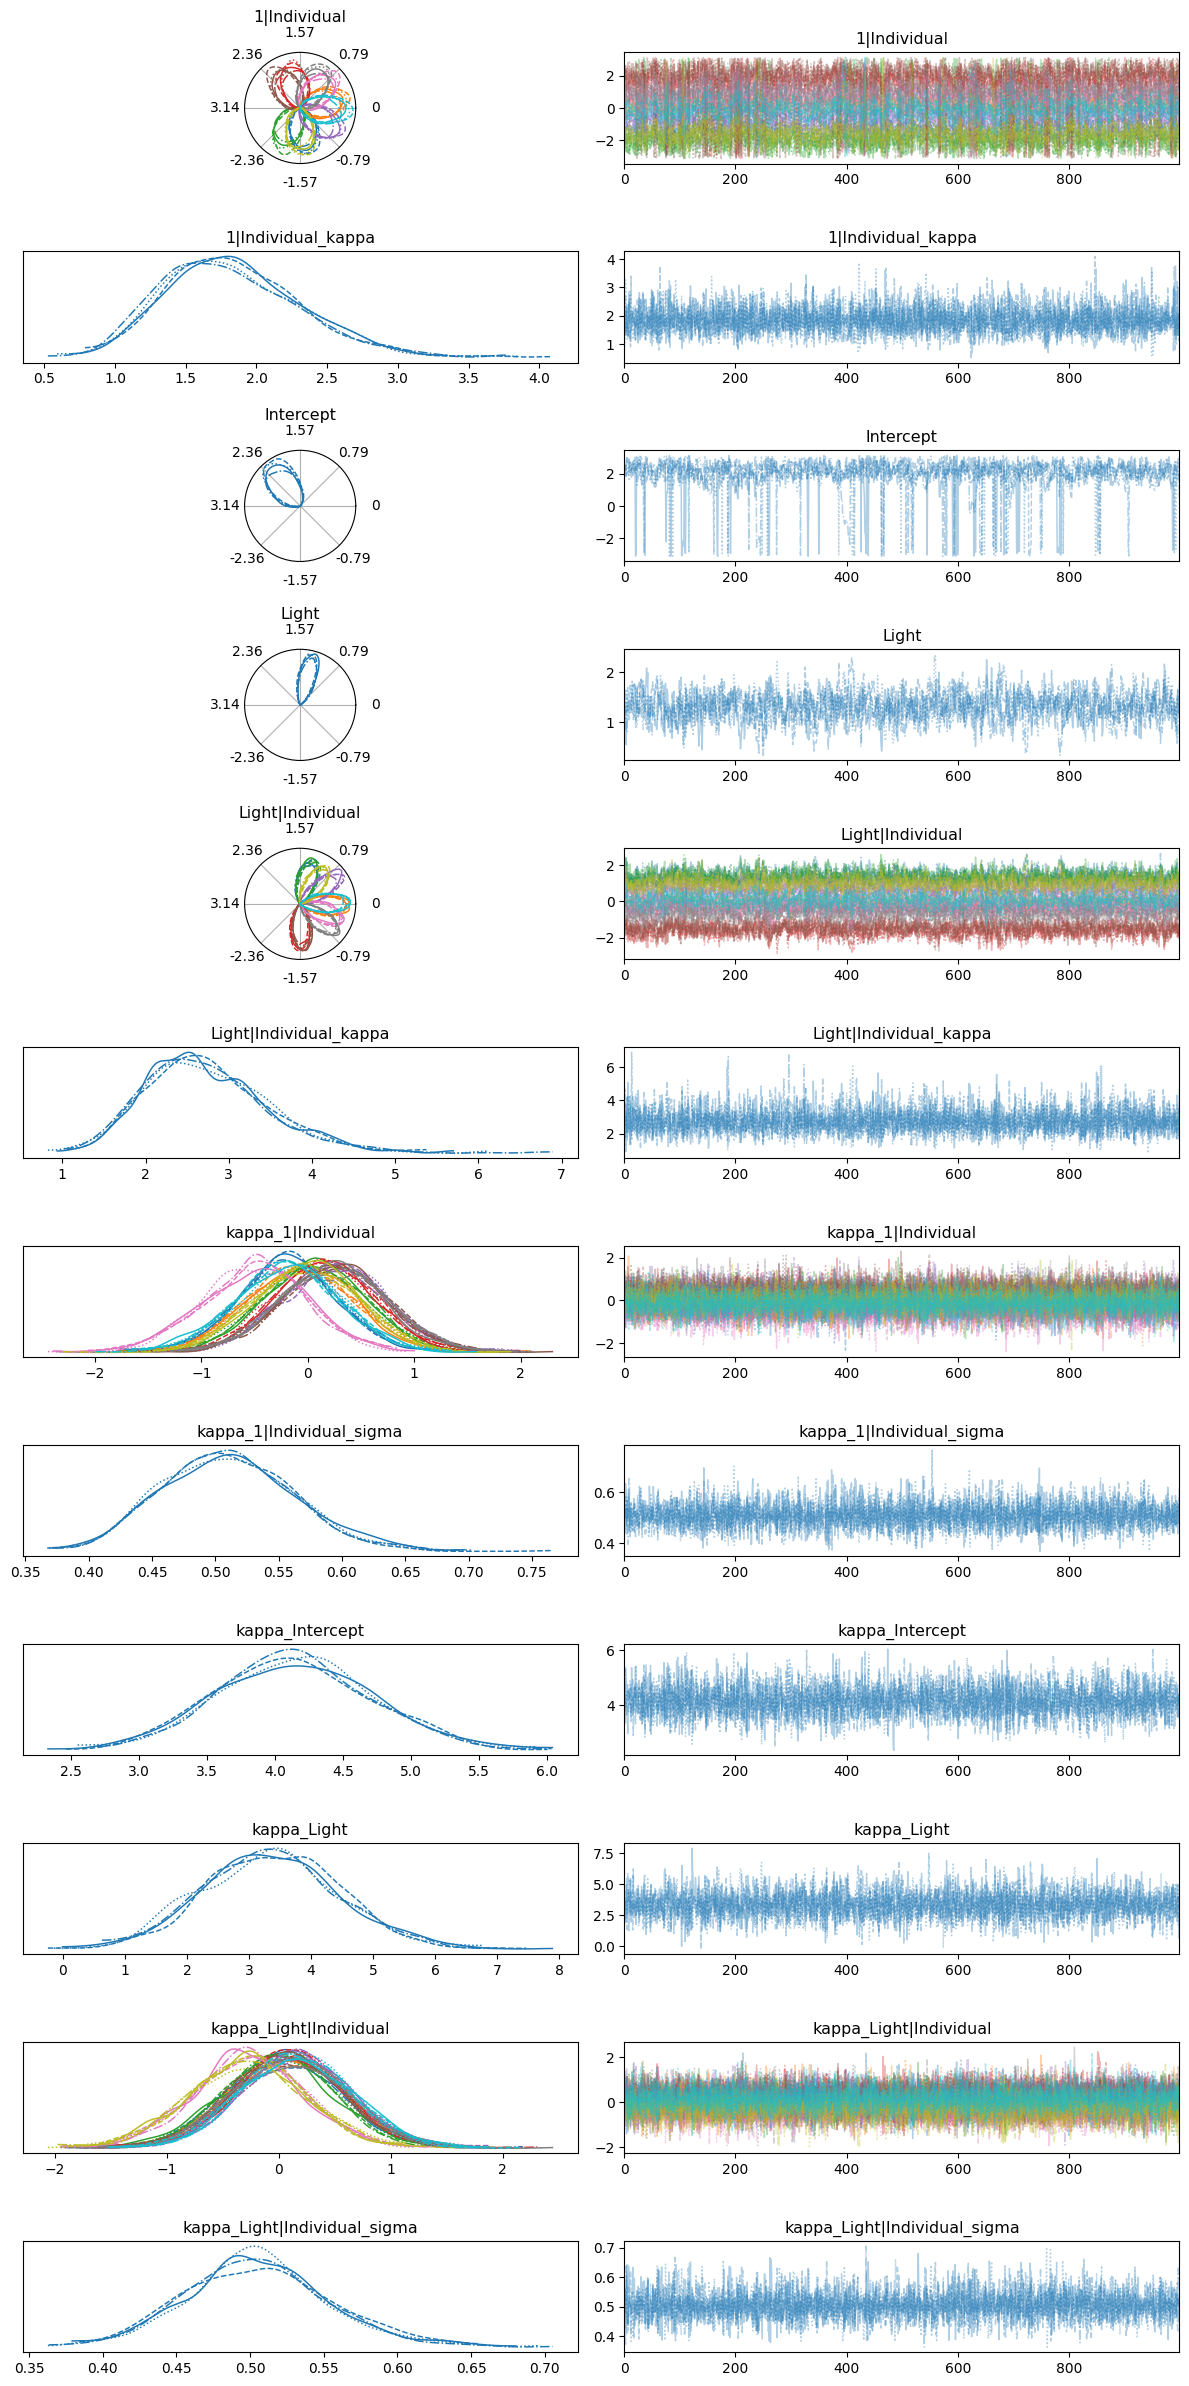

In [36]:
varnms = ["Intercept", "Light", "kappa_Intercept", "kappa_Light"],
#Specify which parameters are circular
cvars = ["Intercept", "Light", "1|Individual", "Light|Individual"]
#transform the circular data for interpretability
idata_hyper_trans = idata_hyper.copy() # set up a variable for transformed data
# for cvar in cvars:
#     idata_hyper_trans.posterior[cvar] = -180*idata_hyper_trans.posterior[cvar]/np.pi # convert each to degrees that will plot clockwise

az.plot_trace(idata_hyper,
            #   var_names=varnms,
              circ_var_names=cvars,
              #circ_var_units='degrees'
              ) #now in degrees and going clockwise, but axis labels are anticlock and start at right
plt.tight_layout()
plt.show()